In [1]:
from src.plot_utils import plot_scatter,plot_map
import os,glob,cmaps,sys
import hydroeval as he
import numpy as np
from pyogrio import read_dataframe
import pandas as pd
import pickle
import shap
import fasttreeshap
from src.myshap import createShapExplanation
import seaborn as sns
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from scipy.stats import pearsonr
from matplotlib.colors import LogNorm
import matplotlib.font_manager as font_manager
font_manager.fontManager.addfont(os.environ['DATA']+'/fonts/Helvetica/Helvetica.ttf')
font_manager.fontManager.addfont(os.environ['DATA']+'/fonts/Helvetica/Helvetica-Bold.ttf')
plt.rc('font', size = 12, family = 'Helvetica')

df_Qmax7 = pd.read_csv('../results/rf_cv10_Qmax7_raw_result.csv')
df_Qmin7 = pd.read_csv('../results/rf_cv10_Qmin7_raw_result.csv')

palette = {'tropical':'#F8D347','dry':'#C7B18A','temperate':"#65C2A5",'cold':"#a692b0",'polar':"#B3B3B3"}

### plot PDF of the target variable

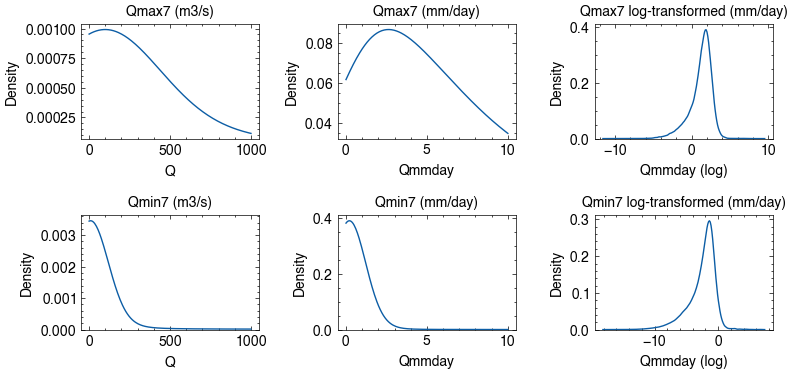

In [5]:
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
fig, axes = plt.subplots(2, 3, figsize=(8,4))
for i,name in enumerate(['Qmax7','Qmin7']):
    if name == 'Qmax7':
        df = df_Qmax7.copy()
    else:
        df = df_Qmin7.copy()
    df['Qmmday'] = df['Q'] / df['gritDarea'] * 86.4
    df['Qmmday (log)'] = np.log(df['Qmmday'])
    sns.kdeplot(df, x = 'Q', ax = axes[i,0], clip = [0, 1000])
    sns.kdeplot(df, x = 'Qmmday', ax = axes[i,1], clip = [0, 10])
    sns.kdeplot(df, x = 'Qmmday (log)', ax = axes[i,2])
    axes[i,0].set_title(f'{name} (m3/s)', fontsize = 10)
    axes[i,1].set_title(f'{name} (mm/day)', fontsize = 10)
    axes[i,2].set_title(f'{name} log-transformed (mm/day)', fontsize = 10)
fig.tight_layout()
fig.savefig('../picture/hist_Qmin7_Qmax7.png', dpi = 600)

### plot a map of the length of records

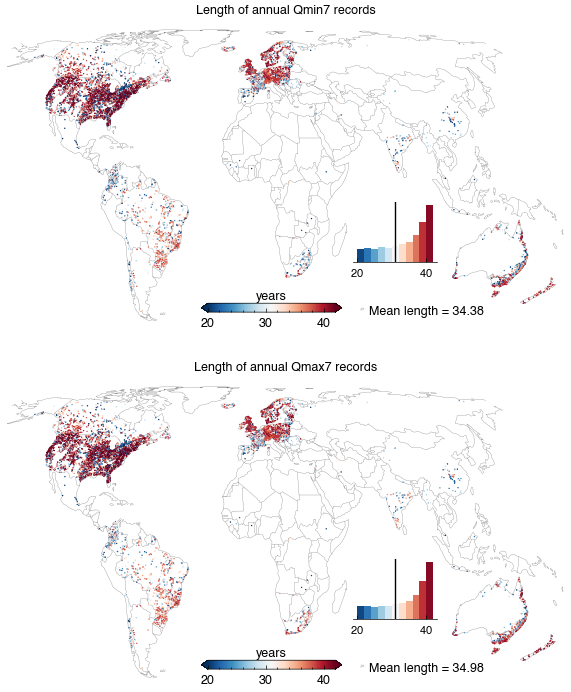

In [7]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8.5), subplot_kw={'projection':ccrs.EqualEarth()})
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
        ax = axes[0]
    else:
        df = df_Qmax7.copy()
        ax = axes[1]
    df_sta = df.groupby(['ohdb_id','ohdb_longitude','ohdb_latitude','climate_label'])['dam'].count().reset_index()
    lons = df_sta.ohdb_longitude.values
    lats = df_sta.ohdb_latitude.values
    vals = df_sta['dam'].values
    vmin = 20
    vmax = 42
    vind = 2
    cmap = 'RdBu_r'
    title = f'Length of annual {name} records'
    label = 'years'
    plot_map(ax, lons, lats, vals, vmin, vmax, vind, cmap, title, label, size = 1, fontSize = 9, norm = None)
    ave0 = df_sta.dam.mean()
    ax.text(.75, .05, 'Mean length = %.2f'%ave0, transform = ax.transAxes, ha = 'center', va = 'top', fontsize = 9)
fig.savefig(f'../picture/length_of_records.png', dpi = 600)

### plot scatterplot

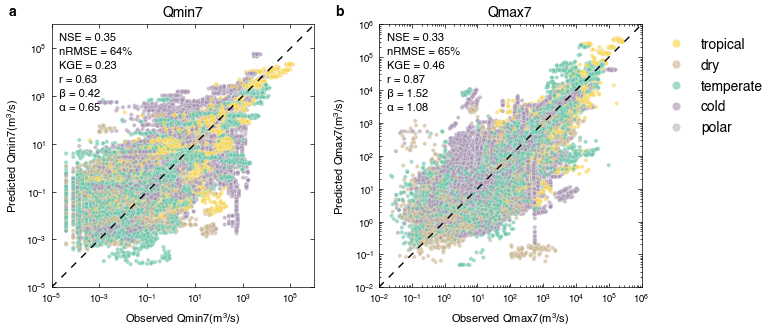

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
plot_scatter(df_Qmin7.Q.values, 
            df_Qmin7['pred'].values, 
            df_Qmin7.climate_label.values, 
            'Observed Qmin7' + '($\mathregular{m^3/s}$)', 
            'Predicted Qmin7' +  '($\mathregular{m^3/s}$)', 
            normColor = 'norm',
            palette = palette,
            fontsize = 8,
            legend = False,
            ax = axes[0])
axes[0].set_title('Qmin7', fontsize = 10)
plot_scatter(df_Qmax7.Q.values, 
            df_Qmax7['pred'].values, 
            df_Qmax7.climate_label.values, 
            'Observed Qmax7' + '($\mathregular{m^3/s}$)', 
            'Predicted Qmax7' +  '($\mathregular{m^3/s}$)', 
            normColor = 'norm',
            palette = palette,
            fontsize = 8,
            ax = axes[1])
sns.move_legend(axes[1], 'upper left', bbox_to_anchor = (1.03, 1), markerscale = 2, fontsize = 10)
axes[1].set_title('Qmax7', fontsize = 10)
axes[0].text(-.15, 1.05, 'a', weight = 'bold', ha = 'center', va = 'center', fontsize = 10, transform = axes[0].transAxes)
axes[1].text(-.15, 1.05, 'b', weight = 'bold', ha = 'center', va = 'center', fontsize = 10, transform = axes[1].transAxes)
axes[0].set_xlim(1e-5, 1e6)
axes[0].set_ylim(1e-5, 1e6)
axes[1].set_xlim(1e-2, 1e6)
axes[1].set_ylim(1e-2, 1e6)
fig.tight_layout()
fig.savefig('../picture/scatter_cv10_rf.png', dpi = 600)

### maps of KGE 

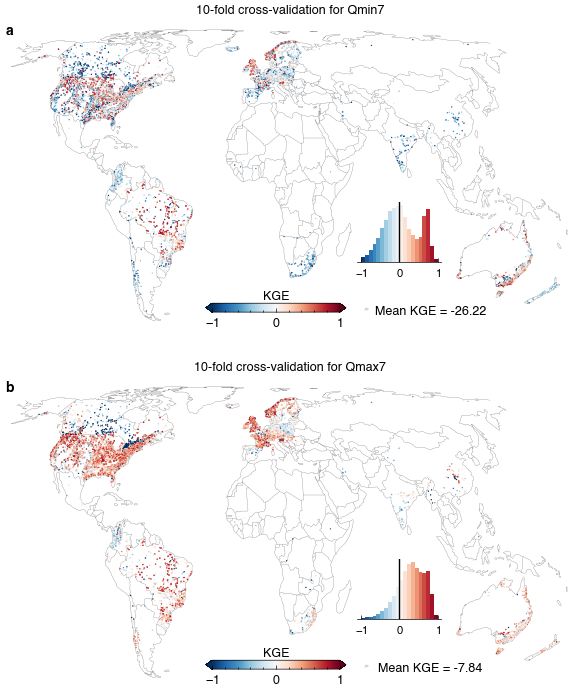

In [2]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8.5), subplot_kw={'projection':ccrs.EqualEarth()})
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
        ax = axes[0]
    else:
        df = df_Qmax7.copy()
        ax = axes[1]
    df_sta = df.groupby(['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label']).apply(
        lambda x: pd.Series(
            he.kge(x.pred.values, x.Q.values).squeeze(), index = ['KGE','r','alpha','beta'])
    ).reset_index()
    lons = df_sta.ohdb_longitude.values
    lats = df_sta.ohdb_latitude.values
    vals = df_sta['KGE'].values
    vmin = -1
    vmax = 1
    vind = .1
    cmap = 'RdBu_r'
    title = f'10-fold cross-validation for {name}'
    label = 'KGE'
    plot_map(ax, lons, lats, vals, vmin, vmax, vind, cmap, title, label, size = 1, fontSize = 9, norm = None)
    ave0 = df_sta.KGE.mean()
    ax.text(.75, .05, 'Mean KGE = %.2f'%ave0, transform = ax.transAxes, ha = 'center', va = 'top', fontsize = 9)
    ax.text(0, 1, ['a','b'][i], transform = ax.transAxes, ha = 'center', va = 'top', fontsize = 10, weight = 'bold')
fig.savefig(f'../picture/map_kge_cv10_rf.png', dpi = 600)

### maps of nRMSE

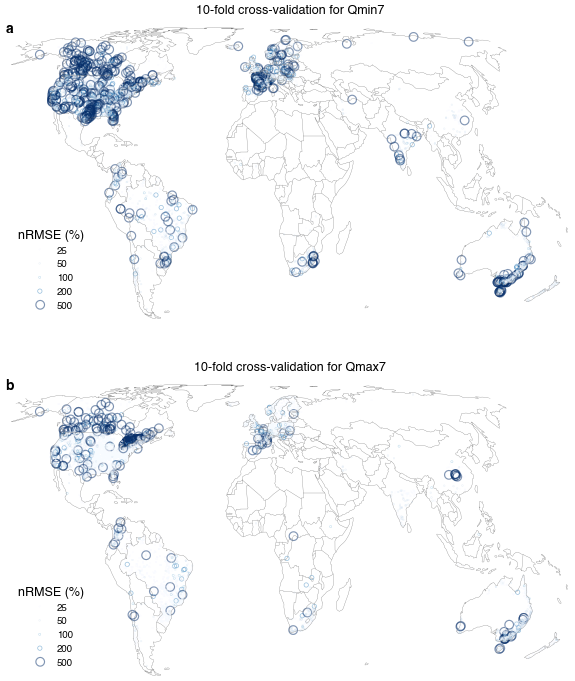

In [69]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8.5), subplot_kw={'projection':ccrs.EqualEarth()})
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
        ax = axes[0]
    else:
        df = df_Qmax7.copy()
        ax = axes[1]
    df_sta = df.groupby(['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label']).apply(
        lambda x: pd.Series(
            [np.sum((x.pred.values-x.Q.values)**2) / np.sum(x.Q.values**2) * 100], index = ['nRMSE'])
    ).reset_index()
    title = f'10-fold cross-validation for {name}'
    label = 'nRMSE (%)'
    size_norm = mpl.colors.BoundaryNorm([0, 50, 80, 100, 150, 200], clip = True, ncolors = 5)
    size_norm = mpl.colors.LogNorm()
    df_sta.loc[df_sta.nRMSE>5000,'nRMSE'] = 5000
    df_sta.loc[df_sta.nRMSE<1,'nRMSE'] = 1
    df_sta['nRMSE1'] = 25
    df_sta.loc[(df_sta.nRMSE>50)&(df_sta.nRMSE<=100),'nRMSE1'] = 50
    df_sta.loc[(df_sta.nRMSE>100)&(df_sta.nRMSE<=200),'nRMSE1'] = 100
    df_sta.loc[(df_sta.nRMSE>200)&(df_sta.nRMSE<=500),'nRMSE1'] = 200
    df_sta.loc[(df_sta.nRMSE>500),'nRMSE1'] = 500
    sns.scatterplot(df_sta, x = 'ohdb_longitude', y = 'ohdb_latitude', hue = 'nRMSE1', size = 'nRMSE1', hue_norm = size_norm, palette = 'Blues',
                    marker = "$\circ$", ec = "face", alpha = .5,
                    sizes = {25:1,50:2,100:4,200:16,500:64}, ax = ax, transform = ccrs.PlateCarree())
    sns.move_legend(ax, 'lower left', bbox_to_anchor = (0, 0), title = 'nRMSE (%)', title_fontsize = 9)
    ax.set_global()
    ax.set_ylim([-6525154.6651, 8625154.6651]) 
    ax.set_xlim([-12662826, 15924484]) 
    ax.spines['geo'].set_linewidth(0)
    ax.coastlines(linewidth = .2, color = '#707070')
    ax.add_feature(cf.BORDERS, linewidth = .2, color = '#707070')
    ax.text(0, 1, ['a','b'][i], transform = ax.transAxes, ha = 'center', va = 'top', fontsize = 10, weight = 'bold')
    ax.set_title(title, fontsize = 9)
fig.savefig(f'../picture/map_nRMSE_cv10_rf.png', dpi = 600)

### boxplots of KGE, r nRMSE

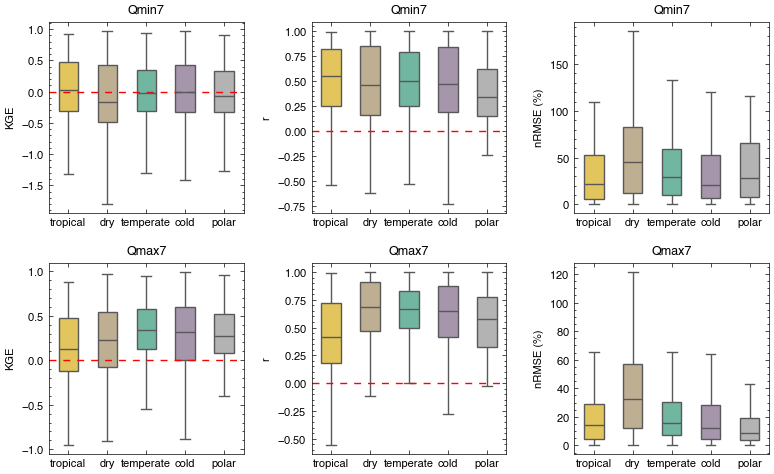

In [19]:
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
import matplotlib.ticker as ticker
fig, axes = plt.subplots(2, 3, figsize = (8, 5))
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
    else:
        df = df_Qmax7.copy()
    df_sta = df.groupby(['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label']).apply(
        lambda x: pd.Series([
            he.kge(x.pred.values, x.Q.values).squeeze()[0],
            np.corrcoef(x.pred.values, x.Q.values)[0,1],
            np.sum((x.pred.values-x.Q.values)**2) / np.sum(x.Q.values**2) * 100
        ], index = ['KGE','r','nRMSE (%)'])
    ).reset_index()
    for j,name1 in enumerate(['KGE','r','nRMSE (%)']):
        sns.boxplot(data = df_sta, x = 'climate_label', y = name1, ax = axes[i,j], hue = 'climate_label', palette = palette, showfliers = False, width = .5)
        axes[i,j].set_title(name, fontsize = 9)
        axes[i,j].set_xlabel(None)
        axes[i,j].xaxis.set_minor_locator(ticker.NullLocator())
        if name1 in ['KGE','r']:
            axes[i,j].axhline(y = 0, ls = (0,(5,5)), color = 'red', lw = 1)
fig.tight_layout()
fig.savefig(f'../picture/boxplot_cv10_rf.png', dpi = 600)

### correlation between bias and basin attributes

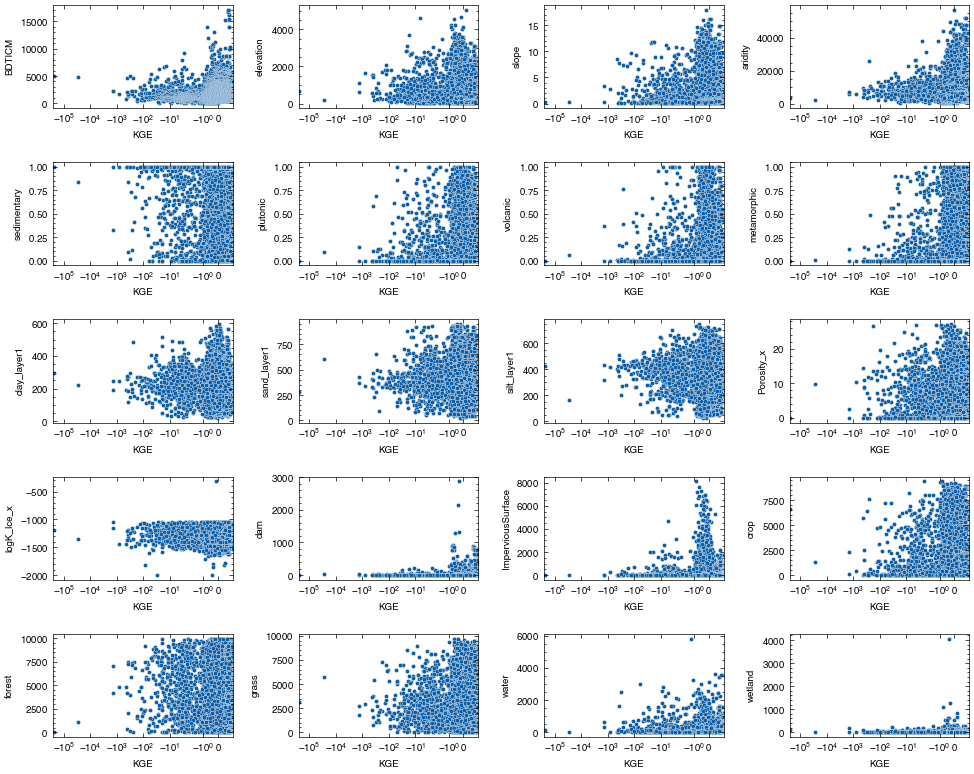

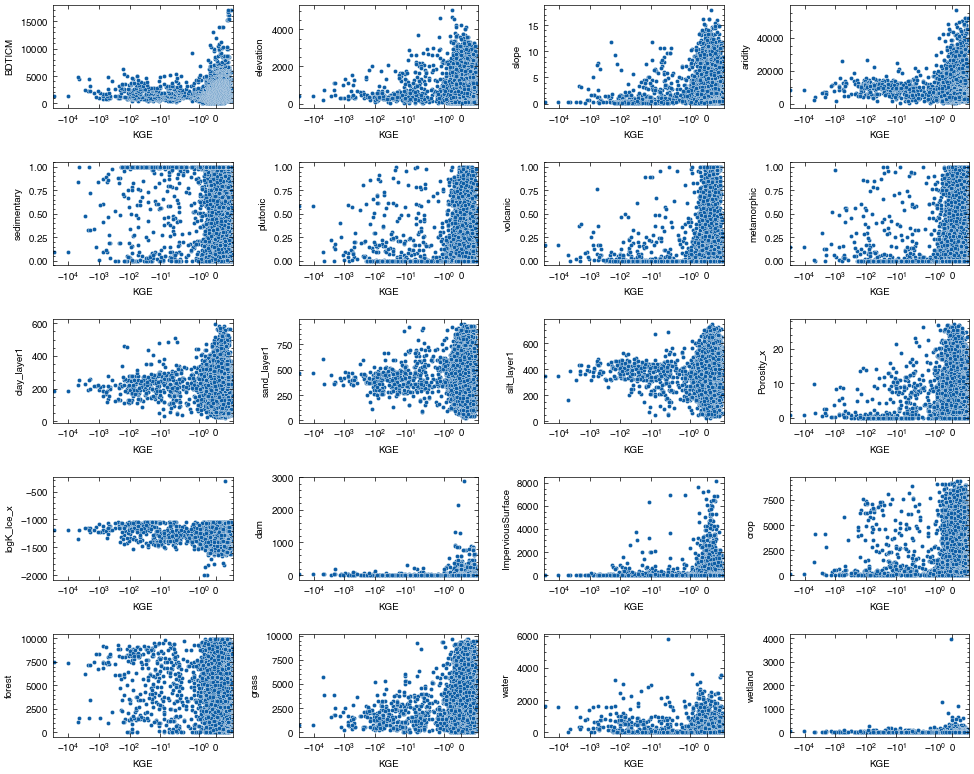

In [5]:
predictors = [  'BDTICM', 'elevation', 'slope', 'aridity', 
                'sedimentary', 'plutonic', 'volcanic', 'metamorphic',
                'clay_layer1', 'sand_layer1', 'silt_layer1', 
                'Porosity_x', 'logK_Ice_x', 'dam', 'ohdb_id'
            ]
lulc = ['ImperviousSurface', 'crop', 'forest', 'grass', 'water', 'wetland']
metric = 'KGE'
for i,name1 in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
    else:
        df = df_Qmax7.copy()
    df_sta = df.groupby(predictors).apply(
        lambda x: pd.Series(
            x[lulc].mean(axis=0).values.tolist() + [
            he.kge(x.pred.values, x.Q.values).squeeze()[0],
            np.corrcoef(x.pred.values, x.Q.values)[0,1],
            np.sum((x.pred.values-x.Q.values)**2) / np.sum(x.Q.values**2) * 100
        ], index = lulc + ['KGE','r','nRMSE (%)'])
    ).reset_index()
    fig, axes = plt.subplots(5, 4, figsize = (10, 8))
    for i,name in enumerate(predictors[:-1]+lulc):
        sns.scatterplot(df_sta, x = metric, y = name, ax = axes.ravel()[i])
        axes.ravel()[i].set_xscale('symlog')
        axes.ravel()[i].set_xlim(None, 1)
    fig.tight_layout()
    fig.savefig(f'../picture/scatter_{metric}_basin_attributes_{name1}.png', dpi = 600)
    

### correlation between bias and catchment area

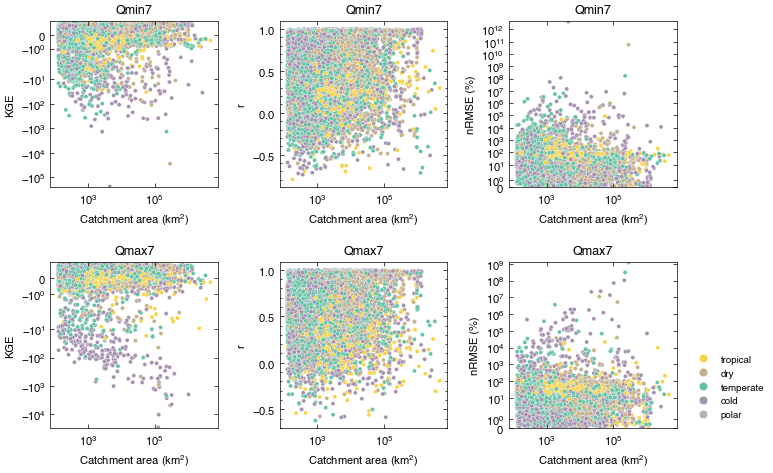

In [10]:
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
fig, axes = plt.subplots(2, 3, figsize = (8, 5))
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
    else:
        df = df_Qmax7.copy()
    df_sta = df.groupby(['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label','gritDarea']).apply(
        lambda x: pd.Series([
            he.kge(x.pred.values, x.Q.values).squeeze()[0],
            np.corrcoef(x.pred.values, x.Q.values)[0,1],
            np.sum((x.pred.values-x.Q.values)**2) / np.sum(x.Q.values**2) * 100
        ], index = ['KGE','r','nRMSE (%)'])
    ).reset_index()
    for j,name1 in enumerate(['KGE','r','nRMSE (%)']):
        if i == 1 and j == 2:
            sns.scatterplot(data = df_sta, x = 'gritDarea', y = name1, ax = axes[i,j], hue = 'climate_label', palette = palette)
            sns.move_legend(axes[i,j], 'lower left', title = None, bbox_to_anchor = (1.05, 0), markerscale = 2)
        else:
            sns.scatterplot(data = df_sta, x = 'gritDarea', y = name1, ax = axes[i,j], hue = 'climate_label', palette = palette, legend = False)
        axes[i,j].set_title(name, fontsize = 9)
        axes[i,j].set_xscale('log')
        if name1 in ['KGE','nRMSE (%)']:
            axes[i,j].set_yscale('symlog')
        if name1 == 'KGE':
            axes[i,j].set_ylim(None, 1)
        if name1 == 'nRMSE (%)':
            axes[i,j].set_ylim(0, None)
        axes[i,j].set_xlabel('Catchment area ($\mathregular{km^2}$)')
fig.tight_layout()
fig.savefig(f'../picture/scatter_darea_metrics_cv10_rf.png', dpi = 600)